In [1]:
# add additional processes to serve as workers 
n_procs = 3
addprocs(n_procs);  

In [2]:
# add present working directory to path from which to load modules
push!(LOAD_PATH, ".") 

# load module DynamicProgramming on each of the processes 
using DynamicProgramming
using Interpolations
for p in workers()
    remotecall_fetch(p, eval, :(using DynamicProgramming))
    remotecall_fetch(p, eval, :(using Interpolations))
end

In [3]:
# nominal parameter value 
@everywhere T1 = 0.680 # seconds in white matter 
@everywhere T2 = 0.090 # seconds in white matter 
@everywhere dT = 0.2   # seconds between acquisitions 
@everywhere sigma = 0.1  # noise strength 
@everywhere theta0 = [exp(-dT/T1); exp(-dT/T2)]

# time horizon 
@everywhere N = 30

# state dimension 
@everywhere n = 6

# initial state
@everywhere x0 = [0.; 0.; 1.; 0; 0; 0]

# define rotation matrices 
@everywhere function Rx(alpha::Float64)
    return [1     0           0     ;
            0 cos(alpha) -sin(alpha);
            0 sin(alpha)  cos(alpha)]
end
@everywhere function Ry(alpha::Float64)
    return [cos(alpha) 0 -sin(alpha);
                0      1      0     ;
            sin(alpha) 0  cos(alpha)]
end
@everywhere function Rz(alpha::Float64)
    return [cos(alpha) -sin(alpha) 0;
            sin(alpha)  cos(alpha) 0;
                0           0      1]
end

# dynamics 
@everywhere function f(t::Int64, x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    x_state = x[1:3]
    x_sensitivity = x[4:6]
    U = Rx(u[1])*Ry(u[2])*Rz(u[3])
    D = [theta[2], theta[2], theta[1]]
    x_state_plus = U*(D.*x_state) + [0; 0; 1-theta[1]]
    x_sensitivity_plus = U*(D.*x_sensitivity) + U*([0; 0; 1].*x_state) + [0; 0; -1]
    return [x_state_plus; x_sensitivity_plus]
end

# test dynamics 
f(1, x0, [0.; 0.; 0.], theta0)

# reward function 
@everywhere function g(x::Array{Float64, 1}, u::Array{Float64, 1}, theta::Array{Float64, 1})
    return x[4]^2 + x[5]^2 
end

# test reward function 
g(x0, [0.; 0.; 0.], theta0)

# define state grid 
@everywhere nx1 = 3 # number of grid points in each dimension  
@everywhere nx2 = 3
@everywhere nx3 = 3
@everywhere nx4 = 3
@everywhere nx5 = 3
@everywhere nx6 = 3
@everywhere xgrid = (
                     linspace(-1., 1., nx1), 
                     linspace(-1., 1., nx2), 
                     linspace(-1., 1., nx3), 
                     linspace(-5., 5., nx4), 
                     linspace(-5., 5., nx5), 
                     linspace(-5., 5., nx6)
                    ) 

# define input grid
@everywhere nu1 = 8
@everywhere nu2 = 8
@everywhere nu3 = 8
@everywhere ugrid = (
                     linspace(-pi, pi-pi/nu1, nu1), 
                     linspace(-pi, pi-pi/nu2, nu2), 
                     linspace(-pi, pi-pi/nu3, nu3)
                    ) 
ugrid

(linspace(-3.141592653589793,2.748893571891069,8),linspace(-3.141592653589793,2.748893571891069,8),linspace(-3.141592653589793,2.748893571891069,8))

In [4]:
# compute value function
@time J = dp_loop(f, g, ugrid, xgrid, theta0, N); 

====== Constructing array J ======
J is size (3,3,3,3,3,3) by 30
====== Array J constructed  ======
Step k = 29
Step k = 28
Step k = 27
Step k = 26
Step k = 25
Step k = 24
Step k = 23
Step k = 22
Step k = 21
Step k = 20
Step k = 19
Step k = 18
Step k = 17
Step k = 16
Step k = 15
Step k = 14
Step k = 13
Step k = 12
Step k = 11
Step k = 10
Step k = 9
Step k = 8
Step k = 7
Step k = 6
Step k = 5
Step k = 4
Step k = 3
Step k = 2
Step k = 1
105.786617 seconds (2.21 M allocations: 108.829 MB, 0.02% gc time)


In [5]:
# compute optimal trajectory from initial condition x0 
x0 = [0.; 0.; 1.; 0.; 0.; 0.]
x_opt, u_opt = dp_rollout(J, x0, f, g, ugrid, xgrid, theta0, N);

In [6]:
using Gadfly
using Colors 

berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
berkeley_gold = RGB((1/256*[224., 158.,  25.])...); 

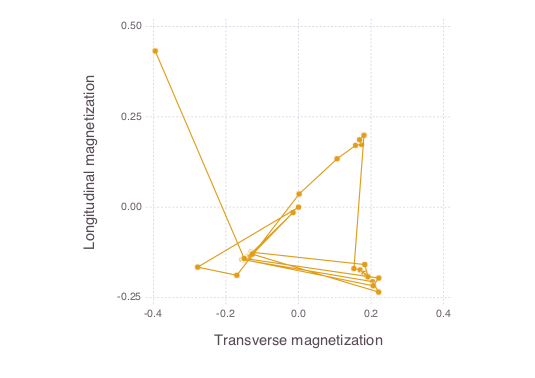

In [7]:
# plot optimal trajectory in phase space 

p = plot(x=x_opt[2, :], y=x_opt[1, :], 
        Guide.XLabel("Transverse magnetization"), 
        Guide.YLabel("Longitudinal magnetization"), 
        Geom.path, Geom.point, Coord.cartesian(fixed=true),
        Theme(default_color=berkeley_gold)
)
draw(SVG("MRI_trajectory.svg", 10cm, 20cm), p)
p

In [8]:
# plot optimal input 

p = plot(x=1:N-1, y=180/pi*u_opt, 
        Guide.XLabel("time"), 
        Guide.YLabel("u<sub>t</sub> (degrees)"), 
        Geom.path, Geom.point, 
        Theme(default_color=berkeley_blue)
)
draw(SVG("MRI_input.svg", 15cm, 10cm), p)
p

LoadError: LoadError: The following aesthetics are required by Geom.line to be of equal length: x, y

while loading In[8], in expression starting on line 9

In [9]:
using Optim
using DataFrames

In [10]:
# confirm that this leads to improvement in parameter estimation error

srand(42) # seed random number generator for reproducible results 

function trajectories(u, x0, f, n, N, theta)
    x = zeros(n, N)
    x[:, 1] = x0
    for t=1:N-1
        x[:, t+1] = f(t, x[:, t], u[t], theta)
    end
    
    return x
end

function negative_log_likelihood(theta, y, f, x0, u, n, N)
    x = (trajectories(u, x0, f, n, N, theta))[2, :]
    noise_level = sigma^2
    l = 0
    for t=1:N
        l = l - (log(y[t]) - log(noise_level)  - (x[t]^2 + y[t]^2)/(2*noise_level) 
                    + y[t]*x[t]/noise_level 
                    + log(besselix(0, y[t]*x[t]/noise_level))
                )
    end
    return l
end

y_nominal_opt = (trajectories(u_opt, x0, f, n, N, theta0))[2, :]
u_rand = pi/2*rand(size(u_opt))
y_nominal_rand = (trajectories(u_rand, x0, f, n, N, theta0))[2, :]

run_max = 1000
theta_hat_opt  = zeros(run_max)
theta_hat_rand = zeros(run_max)
for run_num = 1:run_max
    y_gen_opt = abs(y_nominal_opt + sigma*randn(size(y_nominal_opt)) + sigma*im*randn(size(y_nominal_opt)))
    res = optimize(theta1->negative_log_likelihood([theta1; theta0[2]], y_gen_opt, f, x0, u_opt, n, N), 0, 1)
    theta_hat_opt[run_num] = res.minimum
    
    y_gen_rand = abs(y_nominal_rand + sigma*randn(size(y_nominal_rand)) + sigma*im*randn(size(y_nominal_rand)))
    res = optimize(theta1->negative_log_likelihood([theta1; theta0[2]], y_gen_rand, f, x0, u_rand, n, N), 0, 1)
    theta_hat_rand[run_num] = res.minimum
end

LoadError: LoadError: MethodError: `f` has no method matching f(::Int64, ::Array{Float64,1}, ::Float64, ::Array{Float64,1})
Closest candidates are:
  f(::Int64, ::Array{Float64,1}, !Matched::Array{Float64,1}, ::Array{Float64,1})
while loading In[10], in expression starting on line 28

In [11]:
# plot histogram of estimate errors 

theta_hat_opt_frame  = DataFrame(ThetaEstimateError = theta_hat_opt  - theta0[1],
                                 FlipAngleSequence  = "Optimal"
)

theta_hat_rand_frame = DataFrame(ThetaEstimateError = theta_hat_rand - theta0[1],
                                 FlipAngleSequence  = "Random"
)

theta_hat_frame = vcat(theta_hat_rand_frame, theta_hat_opt_frame)

p = plot(theta_hat_frame, x="ThetaEstimateError", color="FlipAngleSequence", 
        Geom.histogram(bincount=20, position=:dodge), 
        Guide.XLabel("parameter estimate error"), Guide.YLabel("frequency"), 
        Guide.colorkey("Flip angle sequence"),
        Scale.color_discrete_manual(berkeley_blue, berkeley_gold)
)
draw(SVG("MRI_spread.svg", 15cm, 10cm), p)
p

LoadError: LoadError: UndefVarError: theta_hat_opt not defined
while loading In[11], in expression starting on line 3